# SVM based Sentiment Analysis
Let's perform a SVM based Sentiment Analysis based on Support a Vector Machine Model on Twitter Sentiments of US Airline passengers.

**Fill in the blanks**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/My Drive/Colab Notebooks/END/END1
!ls

/content/drive/My Drive/Colab Notebooks/END/END1
'POS Tagging based on Heuristics.ipynb'        Tweets_Airline.csv
'Sentiment Analysis using Naive Bayes.ipynb'   tweets.csv
'Sentiment Analysis using SVM.ipynb'	       tweets.gsheet
'tweets (1).gsheet'


In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Import Libraries

In [6]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

## Import data


In [8]:
data = pd.read_csv("Tweets_Airline.csv")
data.head()
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

## We take only the tweets we are very confident with. We use the BeautifulSoup library to process html encoding present in some tweets.

In [9]:
data_clean = data.copy()
data_clean = data_clean[data_clean['airline_sentiment_confidence'] > 0.65]
data_clean['text_clean'] = data_clean['text'].apply(lambda x: BeautifulSoup(x, "lxml").text)

## For simplicity we are going to distinguish two cases: tweets with negative sentiment and tweets with non-negative sentiment

In [12]:
# --Fill--
data_clean['sentiment'] = data_clean['airline_sentiment'].apply(lambda x: 1 if x == 'negative' else 0) #Hint: Assign 1 to negative class and 0 to rest
data_clean = data_clean.loc[:, ['text_clean', 'sentiment']]
data_clean.head()

,text_clean,sentiment
0,@VirginAmerica What @dhepburn said.,0
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,1
4,@VirginAmerica and it's a really big bad thing...,1
5,@VirginAmerica seriously would pay $30 a fligh...,1


## We split the data into training and testing set:

In [13]:
train, test = train_test_split(data_clean, test_size=0.2, random_state=1)
X_train = train['text_clean'].values
X_test = test['text_clean'].values
y_train = train['sentiment']
y_test = test['sentiment']
# print(train['text_clean'], train['text_clean'].values)

1241     @united flight Cancelled Flightled,  and the u...
4711     @SouthwestAir I never got an email confirmatio...
9943     @USAirways Ann Marie at LGA is the best ticket...
6455     @SouthwestAir Flight 3111 (N614SW) departs @MC...
11285    @USAirways been on hold for over an hour, stil...
                               ...                        
986      @united really?  Someone called in sick and th...
5593     @SouthwestAir well I HAD a car & free place 2 ...
13083    @AmericanAir @maxfitgirl29 next time fly South...
251      @VirginAmerica luggage was severely dented/mis...
14325    @AmericanAir Just landed - crew couldn't have ...
Name: text_clean, Length: 10920, dtype: object ["@united flight Cancelled Flightled,  and the updated one gets me into BWI too Late Flight! I'd be fine with DCA or IAD,  just arriving earlier!  Help!"
 '@SouthwestAir I never got an email confirmation for my ticket, but the credit card was charged.  Phone wait time is crazy. Is there a chat?'
 '@USAi

## Preprocessing the Data

In [14]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

## We are going to use cross validation and grid search to find good hyperparameters for our SVM model. We need to build a pipeline.

In [16]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [21]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, SVC(probability=True, 
                                             kernel= 'rbf', 
                                             class_weight= 'balanced')) #Hint : Linear kernel with balanced class weights

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 11.3min finished


0.9153825021056323

In [22]:
print(grid_svm.best_params_)
print(grid_svm.best_score_)

{'svc__C': 1}
0.903212844087801


## Let's see how the model (with the best hyperparameters) works on the test data:

In [23]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

report_results(grid_svm.best_estimator_, X_test, y_test)

{'acc': 0.8370560234346394,
 'auc': 0.9153873218647166,
 'f1': 0.8733997155049787,
 'precision': 0.9045374189746611,
 'recall': 0.8443344334433444}

## ROC Curve

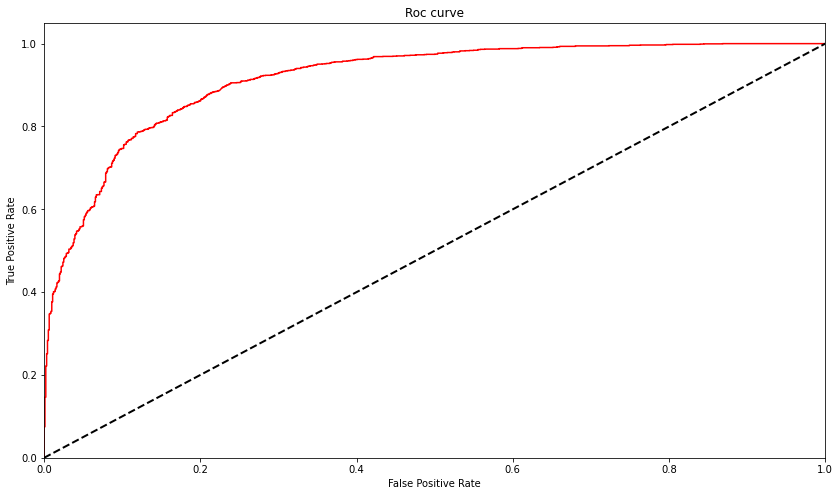

In [24]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

fpr, tpr = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

## Prediction

In [25]:
pred = grid_svm.predict(["flying with @united is always a great experience."])
print('negative' if pred == np.array([1]) else 'not negative')

not negative


In [26]:
pred = grid_svm.predict(["flying with @united is always a great experience. If you don't lose your luggage"])
print('negative' if pred == np.array([1]) else 'not negative')

negative


**It easily distinguishes the text based on context!!**